In [1]:
import sys
sys.path.insert(0, "/home/jogi/git/repository/meta_learner")


import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
%matplotlib inline

from datetime import datetime
from pytz import timezone
import itertools
import copy

import numpy as np
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import init

import numpy as np
import dill
import os
from collections import OrderedDict


from models.rnn_optimizer import MetaLearner, AdaptiveMetaLearnerV1, AdaptiveMetaLearnerV2
from models.rnn_optimizer import kl_divergence
from utils.utils import Experiment, get_model, create_def_argparser, get_experiment, create_logger
from utils.plots import loss_plot, param_error_plot, plot_qt_probs, create_x_val_array, plot_kl_div_parts
from utils.plots import get_exper_loss_data, plot_val_result, plot_exper_losses, plot_parm_loss_steps
from utils.probs import TimeStepsDist, ConditionalTimeStepDist
from utils.config import config
from val_optimizer import validate_optimizer
from utils.regression import RegressionFunction, L2LQuadratic

%load_ext autoreload
%autoreload 2

In [2]:
expers_to_load = [(True, "run_20170629_15_06_49_metaV1_10ep_100ops_retrain_lr5e06_adam"), # quadratics
                  (True, "run_20170625_18_56_22_metaV1_60ep_100ops_retrain_lr5e06_adam"), # quadratics
                  (False, "run_20170627_09_58_35_metaV1_10ep_100ops_lr4e06_adam"),
                  (False, "run_20170627_18_12_50_metaV1_10ep_100ops_retrain_lr1e06_adam"),
                  # ACT V2 model (1 LSTM)
                  (False, "run_20170628_23_23_04_actV2_100ep_100ops_lr1e06_adam"),
                  (False, "run_20170627_13_59_34_actV2_10ep_100ops_retrain_lr1e06_adam"),
                  (False, "run_20170627_15_46_41_actV2_10ep_100ops_retrain_lr1e06_adam")]



In [3]:
without_models = False

experiments = []
models = []
new_experiments = []
explogger = None
m = 0
for e, exp_path in enumerate(expers_to_load):
    if exp_path[0]:
        exp = get_experiment(exp_path[1])
        print("{} Loading model {}".format(m, exp.args.model))
        
        experiments.append(exp)
        if explogger is None:
            explogger = create_logger(exp, file_handler=False)
        m += 1
        if not without_models:
            models.append(get_model(exp, exp.args.x_dim, retrain=True, logger=explogger))
        new_experiments.append(copy.deepcopy(exp))
        new_experiments[-1].reset_val_stats()


0 Loading model metaV1_quadratic_100ops
Using cuda for MetaLearner


INFO - INFO - loaded existing model from file logs/run_20170629_15_06_49_metaV1_10ep_100ops_retrain_lr5e06_adam/metaV1_quadratic_100ops.pkl
INFO - INFO - loaded existing model from file logs/run_20170625_18_56_22_metaV1_60ep_100ops_retrain_lr5e06_adam/metaV1_lr5e-06_adam_100ops.pkl


['linear1.weight', 'linear1.bias', 'lstms.0.fc_i2h.weight', 'lstms.0.fc_i2h.bias', 'lstms.0.fc_h2h.weight', 'lstms.0.fc_h2h.bias', 'lstms.1.fc_i2h.weight', 'lstms.1.fc_i2h.bias', 'lstms.1.fc_h2h.weight', 'lstms.1.fc_h2h.bias', 'linear_out.weight']
1 Loading model metaV1_lr5e-06_adam_100ops
Using cuda for MetaLearner
['linear1.weight', 'linear1.bias', 'lstms.0.fc_i2h.weight', 'lstms.0.fc_i2h.bias', 'lstms.0.fc_h2h.weight', 'lstms.0.fc_h2h.bias', 'lstms.1.fc_i2h.weight', 'lstms.1.fc_i2h.bias', 'lstms.1.fc_h2h.weight', 'lstms.1.fc_h2h.bias', 'linear_out.weight', 'linear_out.bias']


[ 0.00096361  0.00096334  0.00096313  0.00096276  0.00096259]
[ 0.00045186  0.00045177  0.00045162  0.00045155  0.0004514 ]


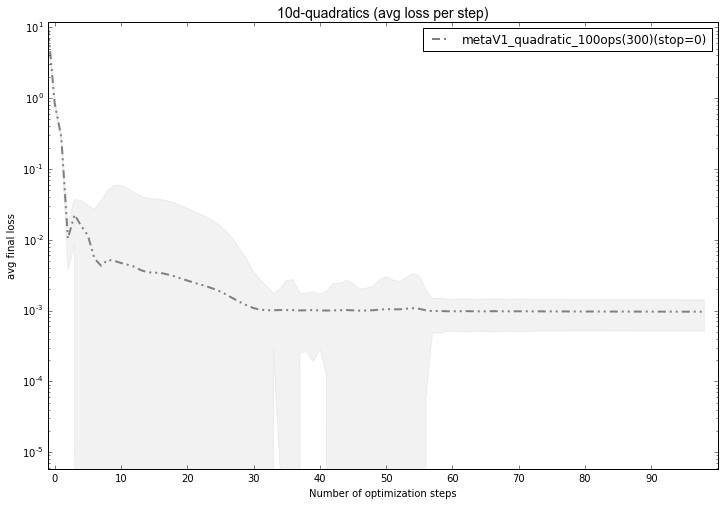

In [7]:
# new_exp_only = [new_experiments[1], new_experiments[2], new_experiments[3] ] #, new_experiments[4]]
best_val_runs, lowest_value = plot_val_result([new_experiments[0]], do_show=True, 
                                              do_save=False, 
                                              plot_best=False,
                                              fig_name="10d_quadratics_with_stddev", 
                                              loss_type="loss",
                                              max_step=100,
                                              sort_exper="10d-quadratics",
                                              log_scale=True)

INFO - Successfully saved fig logs/run_20170602_19_20_08_actV2_60ep_20ops_lr1e05_adam/qt_T_dist_train_actV2_60ep_20ops.png


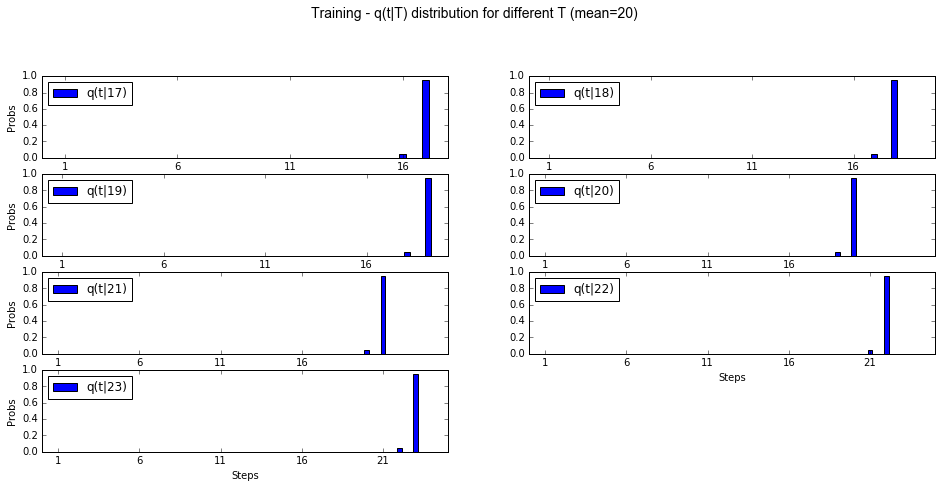

In [12]:
plot_qt_probs(experiments[1], data_set="train", show=True, plot_prior=False, save=True)

actV2_lr1e-05_adam_10ops


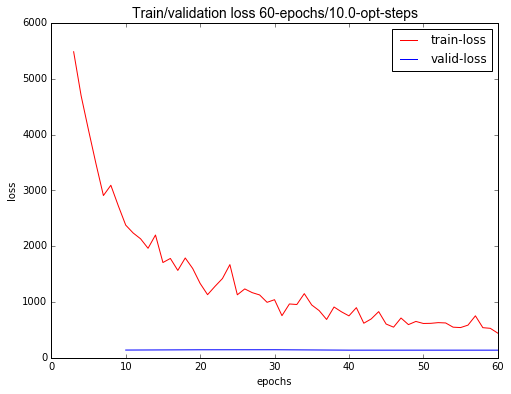

actV2_lr1e-05_adam_20ops


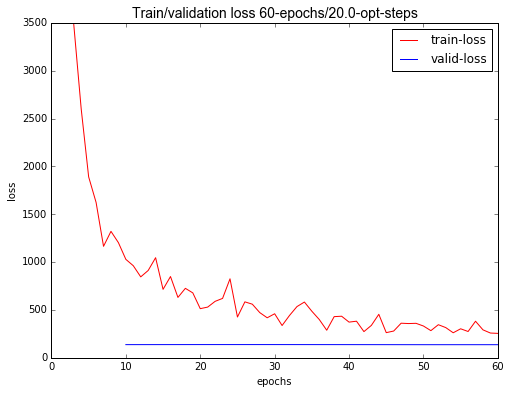

actV2_lr1e-05_adam_40ops


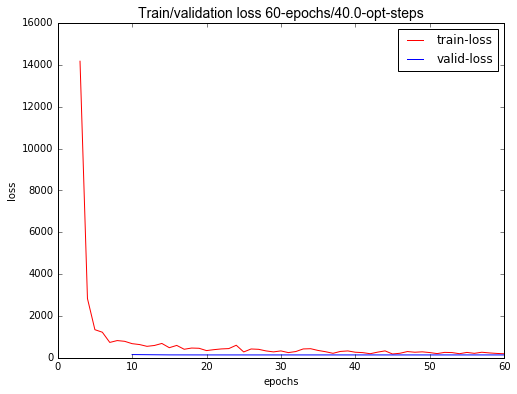

In [4]:
# exp_error_curves = [experiments[0],  experiments[3]]
for exp, mdl in zip(experiments, models):
    print(mdl.name)
    loss_plot(exp, loss_type="loss", save=False, validation=True, show=True)


INFO - Successfully saved fig figures/expv5_val_results_1000_loss_10ops_12_01_09.png


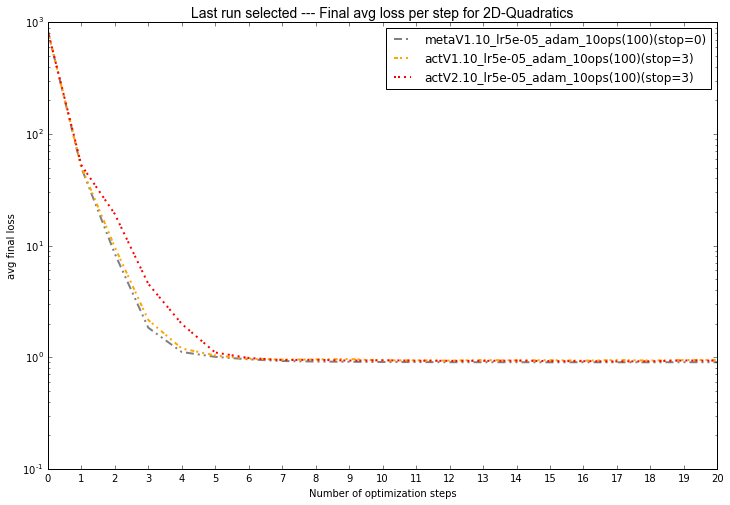

In [27]:
# eval_new_val_expers = [new_experiments[0], new_experiments[3]] #, new_experiments[5]]

best_val_runs, lowest_value = plot_val_result(new_experiments, 
                                              do_show=True, 
                                              do_save=True, 
                                              plot_best=False,
                                              loss_type="loss",
                                              fig_name="expv5_val_results_1000_loss_10ops")

In [14]:
for exp in experiments:
    print(exp.config.max_val_opt_steps)

40
40
40
40
50
40


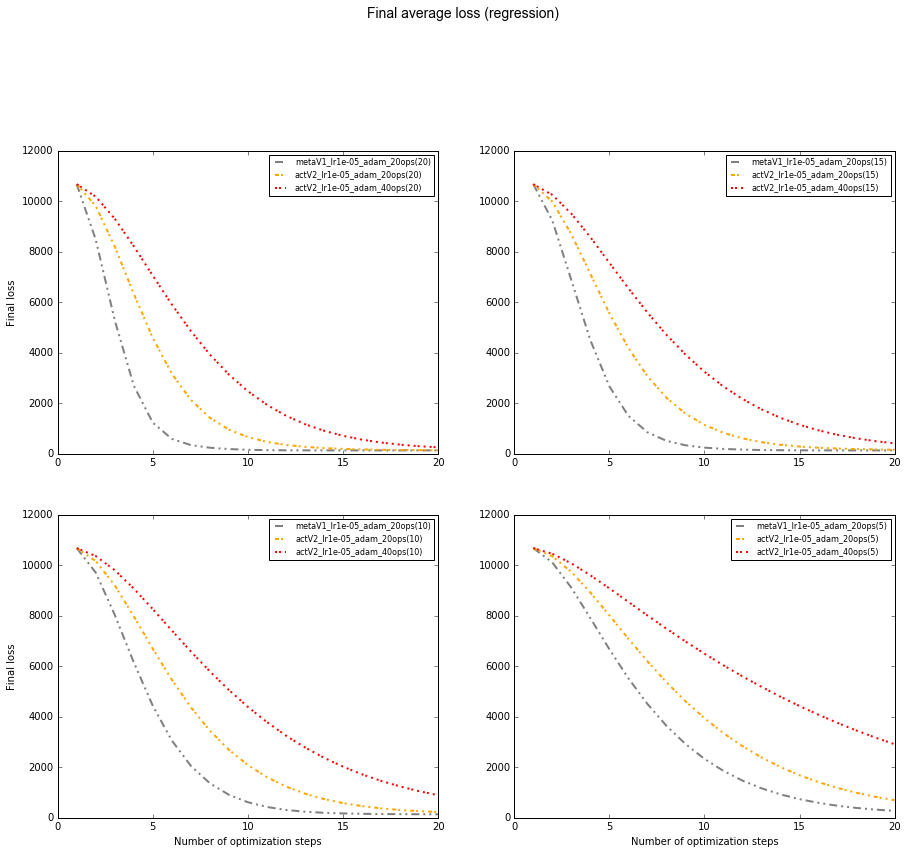

In [5]:
# eval_expers = new_exp_only = [experiments[0], experiments[1], experiments[2]]
plot_parm_loss_steps(experiments, num_of_plots=4, do_show=True, 
                     do_save=False, loss_type="loss", log_scale=False, max_step=20,
                    fig_name="metaV2_val_loss_during_training")

In [2]:
val_funcs = RegressionFunction(n_funcs=20000, n_samples=10, stddev=1.0, 
                             x_dim=10, use_cuda=True)
with open("data/val_funcs_20000_10_1.0_10.dll", 'wb') as f:
     dill.dump(val_funcs, f)
print("Success")

Success


In [4]:
"""
    Create some new validation functions
"""
num_of_val_funcs = 20000
val_funcs = L2LQuadratic(batch_size=num_of_val_funcs, num_dims=10, stddev=0.01, use_cuda=True)
print("Ready")

Ready


In [4]:
with open("data/test_funcs_20000.dll", 'rb') as f:
    val_funcs = dill.load(f)
print("Success")

Success


In [9]:
val_funcs = RegressionFunction(n_funcs=20000, n_samples=10, stddev=1., 
                             x_dim=10, use_cuda=True)
print("Ready")

Ready


In [5]:
print(len(new_experiments))
exp_idx = 0
max_steps = 100
new_experiments[exp_idx].epoch = 300
new_experiments[exp_idx].config.max_val_opt_steps = max_steps
new_experiments[exp_idx].config.T = max_steps
# the same object for the validation data
model = models[exp_idx]
model.opt_step_hist_val = np.zeros(new_experiments[exp_idx].config.max_val_opt_steps)
model.qt_hist_val = OrderedDict([(i, np.zeros(i)) 
                                 for i in np.arange(1, new_experiments[exp_idx].config.max_val_opt_steps + 1)])
print("Validating model {}".format(model.name))

if "act" in model.name:
    model.init_qt_statistics(new_experiments[exp_idx].config)

validate_optimizer(model, new_experiments[exp_idx], explogger, val_set=val_funcs, 
                   max_steps=max_steps, verbose=False, plot_func=False, show_plot=False, save_plot=False,
                   num_of_plots=5, save_model=False, save_qt_prob_funcs=True)

INFO - ---------------------------------------------------------------------------------------
INFO - INFO - Epoch 300: Validating model metaV1_quadratic_100ops with 20000 functions


2
Validating model metaV1_quadratic_100ops


INFO - INFO - Epoch 300, elapsed time 17.46 seconds: 
INFO - INFO - Epoch 300: Final validation stats: total-step-losses / final-step loss / param-loss: 11.36/0.0009623/0.101
INFO - INFO - Epoch 300: Final step param-losses: [ 0.001  0.051  0.137  0.107  0.092  0.097  0.102  0.102  0.101  0.101
  0.101  0.101  0.101  0.101  0.101  0.101  0.101  0.101  0.101  0.101
  0.101  0.101  0.101  0.101  0.101  0.101  0.101  0.101  0.101  0.101
  0.101  0.101  0.101  0.101  0.101  0.101  0.101  0.101  0.101  0.101
  0.101  0.101  0.101  0.101  0.101  0.101  0.101  0.101  0.101  0.101
  0.101  0.101  0.101  0.101  0.101  0.101  0.101  0.101  0.101  0.101
  0.101  0.101  0.101  0.101  0.101  0.101  0.101  0.101  0.101  0.101
  0.101  0.101  0.101  0.101  0.101  0.101  0.101  0.101  0.101  0.101
  0.101  0.101  0.101  0.101  0.101  0.101  0.101  0.101  0.101  0.101
  0.101  0.101  0.101  0.101  0.101  0.101  0.101  0.101  0.101  0.101
  0.101]
INFO - INFO - Epoch 300: Final step losses: [  1.0016e+0

In [ ]:
INFO - INFO - Epoch 300: Final validation stats: total-step-losses / final-step loss / param-loss: 1.269e+03/9.757/
            24.96
INFO - INFO - Epoch 300: Final step losses: [ 64.817  57.507  45.549  33.143  23.862  19.47   18.647  18.385  17.289
  15.932  14.965  14.353  13.858  13.41   13.025  12.701  12.41   12.143
  11.913  11.726  11.576  11.45   11.339  11.24   11.152  11.074  11.005
  10.94   10.876  10.814  10.755  10.7    10.651  10.606  10.565  10.526
  10.489  10.454  10.421  10.39   10.361  10.334  10.308  10.284  10.26
  10.238  10.217  10.196  10.177  10.158  10.14   10.123  10.107  10.092
  10.077  10.063  10.05   10.037  10.025  10.013  10.002   9.991   9.981
   9.971   9.961   9.951   9.942   9.934   9.925   9.917   9.909   9.902
   9.894   9.887   9.88    9.874   9.867   9.861   9.855   9.849   9.844
   9.838   9.833   9.827   9.822   9.817   9.813   9.808   9.803   9.799
   9.795   9.79    9.786   9.782   9.778   9.775   9.771   9.767   9.764
   9.76    9.757]

In [156]:
# exper = get_experiment('run_20170515_13_53_49_actV2_20ep_10ops_lr5e05_adam')
exper = get_experiment("run_20170525_19_39_19_actV2_30ep_20ops_lr5e05_adam")

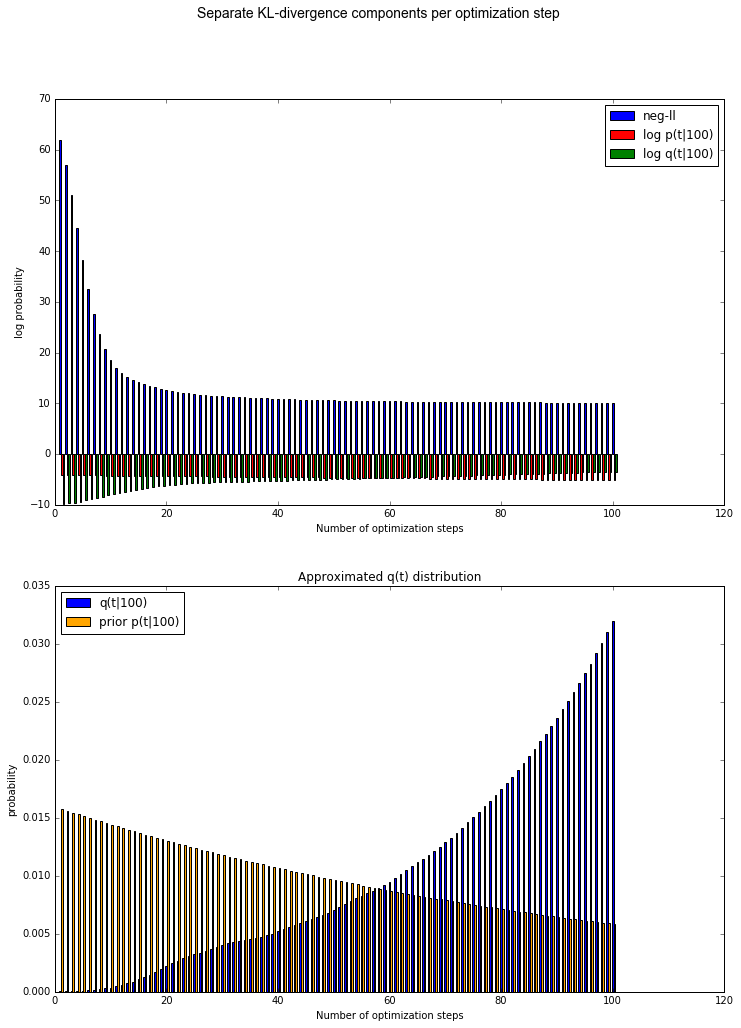

In [9]:
# 
plot_kl_div_parts(new_experiments[1], save=False, show=True, final_terms=False, log_qt=True, plot_prior=True,
                 fig_name="kl_parts_without_tanh")

INFO - Successfully saved fig logs/run_20170628_23_23_04_actV2_100ep_100ops_lr1e06_adam/qt_T_dist_val_actV2_100ep_100ops.png


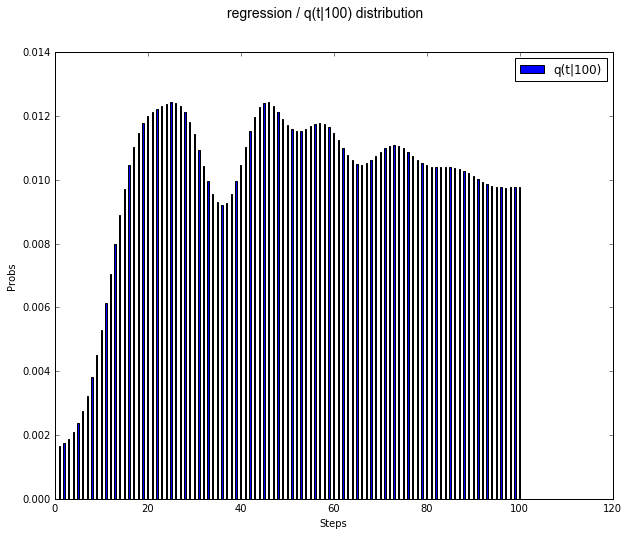

In [15]:
plot_qt_probs(new_experiments[0], data_set="val", save=True, show=True, 
              plot_prior=False, height=20, width=20) #, plot_idx=[200])

In [122]:
from utils.plots import create_exper_label
num_of_plots = 13
T0 = 23
fig = plt.figure(figsize=(8, 25))

for i in range(1, num_of_plots+1):
    T = T0+i
    index = np.arange(1, T+1).astype(int)
    qt = exper.val_stats["qt_hist"][30][T]
    ax1 = plt.subplot(num_of_plots, 1, i)
    plt.bar(index, qt, 0.3, label="q(t|{})".format(T))
    ax1.legend(loc="best")
    
fig_name = "_" + "val" + "_" + create_exper_label(exper)
fig_name = os.path.join(exper.output_dir, config.qt_dist_prefix + fig_name + ".png")
plt.savefig(fig_name, bbox_inches='tight')
plt.close()

[ 0.19309185  0.25614058  0.24058133  0.1808318   0.12935445]
[ 93.69465637  92.56275177  92.43516541  92.43141174  92.43121338
  92.42720032]
[ 0.11887669  0.23429963  0.27020574  0.21978717  0.15683077]
[ 104.62787628   92.92465973   92.43505859   92.42867279   92.42709351
   92.42713928]
[ 0.00903103  0.06211803  0.27155532  0.37283278  0.28446285]
[ 148.68551636  108.54633331   92.52172089   92.56498718   92.44163513
   92.43159485]
[ 0.02397113  0.11330524  0.29825712  0.32578054  0.23868597]
[ 130.93403625  101.6027832    92.51012421   92.4836731    92.43185425
   92.42990875]
[ 0.10979466  0.24725738  0.27810491  0.21425693  0.15058612]
[ 99.56502533  92.709198    92.44354248  92.42796326  92.42944336
  92.42945862]
[ 0.0390434   0.16535978  0.31182257  0.28158466  0.20218959]
[ 118.25817871   95.21542358   92.51622772   92.43270111   92.42834473
   92.43013   ]


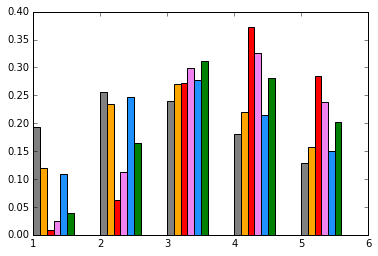

In [155]:
func_idx = [1, 15, 2499, 4999, 7499, 9999]
bar_width = 0.1
p_colors = ['grey', 'orange', 'red', 'violet', 'dodgerblue', 'green', 'darkviolet']
    
for i, idx in enumerate(func_idx):
    qt = exper.val_stats["qt_funcs"][5][idx]
    loss = exper.val_stats["loss_funcs"][idx,0:5+1]
    print(qt)
    print(loss)
    index = np.arange(1, len(qt)+1)
    plt.bar(index+ (i*bar_width), qt, bar_width, color=p_colors[i], label="f_{}".format(idx))

In [8]:
experiments[0].val_stats["loss_funcs"].shape

(15000, 101)

0.0137088933576
36
min/max 28/99 - Mean step 37.6 / stddev 5.7 / median 36.0


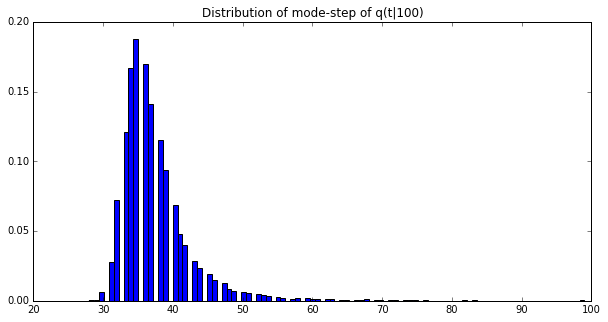

In [22]:
print(np.max(new_experiments[3].val_stats["qt_funcs"][100][1]))
print(np.argmax(new_experiments[3].val_stats["qt_funcs"][100][1]))
max_idx_probs = np.argmax(new_experiments[3].val_stats["qt_funcs"][100], 1)
print("min/max {}/{} - Mean step {:.1f} / stddev {:.2} / median {}".format(np.min(max_idx_probs), np.max(max_idx_probs),
        np.mean(max_idx_probs), np.std(max_idx_probs), np.median(max_idx_probs)))
best_idx = np.argmin(max_idx_probs)
worst_idx = np.argmax(max_idx_probs)
# print(new_experiments[3].val_stats["qt_funcs"][100][worst_idx])
# print(new_experiments[3].val_stats["loss_funcs"][worst_idx])
fig = plt.figure(figsize=(10,5))
plt.title("Distribution of mode-step of q(t|100)")
_ = plt.hist(max_idx_probs, bins=101, normed=True)